# Proceso ETL - Analisis Frecuentista

In [1]:
# Librerias base datos

import csv
from sqlalchemy import create_engine
from sqlalchemy import Column
from sqlalchemy import ForeignKey
from sqlalchemy import Integer
from sqlalchemy import String
from sqlalchemy.orm import declarative_base
from sqlalchemy.orm import relationship

from sqlalchemy.orm import Session

# Librerias ML
import string
import re

import numpy as np                                                               
import matplotlib.pyplot as plt

#import nltk # imports the natural language toolkit
import pandas as pd
import plotly

from collections import Counter
from datetime import datetime
#from sklearn.feature_extraction.text import CountVectorizer

# Libreria computacion en paralelo

import dask.dataframe as dd
from dask.diagnostics import ProgressBar 
from dask.distributed import Client, progress
import dask.bag as db

import nltk

nltk.download('punkt') ## Tokenizer

from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from functools import partial

[nltk_data] Downloading package punkt to C:\Users\ad-
[nltk_data]     gm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Cargar bases

In [2]:
complaint_dataset = pd.read_csv("Datasets/complaint_data.csv")

state_population_dataset = pd.read_csv("Datasets/estados.csv")

In [3]:
complaint_dataset.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,08/09/2015,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,Company chooses not to provide a public response,Experian Information Solutions Inc.,NJ,08872,NaN,Consent not provided,Web,08/09/2015,Closed with non-monetary relief,Yes,No,1509954
1,12/23/2019,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,NaN,NaN,AES/PHEAA,MA,019XX,NaN,NaN,Web,12/23/2019,Closed with explanation,Yes,NaN,3475943
2,01/29/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"EQUIFAX, INC.",NY,10801,NaN,Consent not provided,Web,01/30/2019,Closed with non-monetary relief,Yes,NaN,3136759
3,08/19/2015,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,Company chooses not to provide a public response,WELLS FARGO & COMPANY,CA,94526,NaN,Consent not provided,Web,08/19/2015,Closed with explanation,Yes,No,1527601
4,03/04/2016,Credit card,NaN,Billing disputes,NaN,I am dissatisfied with the current outcome of ...,NaN,DISCOVER BANK,NV,891XX,NaN,Consent provided,Web,03/04/2016,Closed with explanation,Yes,Yes,1816726


# Analisis 1: Quejas por producto

In [4]:
per_product = complaint_dataset[["Complaint ID","Product"]]

per_product = per_product.replace( {"Credit card":"Credit card or prepaid card",
                                    "Credit reporting":"Credit reporting, credit repair services, or other personal consumer reports",
                                    "Money transfers":"Money transfer, virtual currency, or money service",
                                    "Payday loan":"Payday loan, title loan, or personal loan",
                                    "Virtual currency":"Money transfer, virtual currency, or money service"
                                    } )

per_product = per_product.groupby(["Product"]).count()

per_product = per_product.rename( columns={'Complaint ID': 'Count'} )

per_product.head(100)

,Count
Product,
Bank account or service,86206
Checking or savings account,55452
Consumer Loan,31604
Credit card or prepaid card,154460
"Credit reporting, credit repair services, or other personal consumer reports",463249
Debt collection,275584
"Money transfer, virtual currency, or money service",19114
Mortgage,293191
Other financial service,1059


# Analisis 2: Quejas por issue

In [5]:
per_issue = complaint_dataset[["Complaint ID","Issue"]]

per_issue = per_issue.groupby(["Issue"], as_index=False).count()

per_issue = per_issue.rename( columns={'Complaint ID': 'Count'} )

per_issue.head()

,Issue,Count
0,APR or interest rate,5506
1,"Account opening, closing, or management",37961
2,Account terms and changes,484
3,Adding money,202
4,Advertising,126


# Analisis 3: Quejas por issue y producto

In [6]:
per_product_issue = complaint_dataset[["Complaint ID","Product","Issue"]]

per_product_issue = per_product_issue.replace( {"Credit card":"Credit card or prepaid card",
                                    "Credit reporting":"Credit reporting, credit repair services, or other personal consumer reports",
                                    "Money transfers":"Money transfer, virtual currency, or money service",
                                    "Payday loan":"Payday loan, title loan, or personal loan",
                                    "Virtual currency":"Money transfer, virtual currency, or money service"
                                    } )

per_product_issue = per_product_issue.groupby(["Product","Issue"], as_index=False).count()

per_product_issue_grouped = per_product_issue.rename( columns={'Complaint ID': 'Count'} )

per_product_issue_max = per_product_issue_grouped.sort_values(by=['Product', 'Count'], ascending=False).drop_duplicates(subset='Product')

per_product_issue_grouped.head(100)

,Product,Issue,Count
0,Bank account or service,"Account opening, closing, or management",37961
1,Bank account or service,Deposits and withdrawals,22851
2,Bank account or service,"Making/receiving payments, sending money",7404
3,Bank account or service,Problems caused by my funds being low,11845
4,Bank account or service,Using a debit or ATM card,6145
...,...,...,...
95,"Credit reporting, credit repair services, or o...",Credit monitoring or identity theft protection...,3399
96,"Credit reporting, credit repair services, or o...",Credit reporting company's investigation,16883
97,"Credit reporting, credit repair services, or o...",Dealing with your lender or servicer,1
98,"Credit reporting, credit repair services, or o...",Excessive fees,75


In [7]:
# Maximo problema por producto
per_product_issue_max.head(50)

,Product,Issue,Count
232,Vehicle loan or lease,Managing the loan or lease,5381
216,Student loan,Dealing with my lender or servicer,17630
213,Prepaid card,Unauthorized transactions/trans. issues,1325
179,"Payday loan, title loan, or personal loan",Charged fees or interest you didn't expect,3126
167,Other financial service,Fraud or scam,379
154,Mortgage,"Loan modification,collection,foreclosure",112309
129,"Money transfer, virtual currency, or money ser...",Fraud or scam,5987
119,Debt collection,Cont'd attempts collect debt not owed,60682
106,"Credit reporting, credit repair services, or o...",Incorrect information on your report,191833
77,Credit card or prepaid card,Problem with a purchase shown on your statement,15768


# Analisis 3: Quejas por cada 100k habitantes

In [8]:
per_state = complaint_dataset[["Complaint ID","State"]]

per_state = per_state.groupby(["State"], as_index=False).count()

per_state = per_state.rename( columns={'Complaint ID': 'complaint_count'} )

per_state.head(5)

,State,complaint_count
0,AA,25
1,AE,536
2,AK,1531
3,AL,17401
4,AP,386


In [9]:
state_data = state_population_dataset[["estate","abreviacion","poblacion"]].rename( columns={'estate': 'full_name', "abreviacion":"State", "poblacion":"population"} )

per_state_10 = per_state.merge(state_data, on = "State", how="left")

per_state_10 = per_state_10[per_state_10['population'].notnull()]

per_state_10.head()

,State,complaint_count,full_name,population
2,AK,1531,Alaska,732673.0
3,AL,17401,Alabama,5074300.0
5,AR,7150,Arkansas,3045640.0
7,AZ,30622,Arizona,7359200.0
8,CA,199148,California,39029300.0


In [10]:
per_state_10["complains_per_100k"] = round(( per_state_10["complaint_count"] / per_state_10["population"] ) * 100000, 2)

per_state_10.head(20)

,State,complaint_count,full_name,population,complains_per_100k
2,AK,1531,Alaska,732673.0,208.96
3,AL,17401,Alabama,5074300.0,342.92
5,AR,7150,Arkansas,3045640.0,234.76
7,AZ,30622,Arizona,7359200.0,416.11
8,CA,199148,California,39029300.0,510.25
9,CO,22917,Colorado,5839930.0,392.42
10,CT,16089,Connecticut,3626210.0,443.69
12,DE,6929,Delaware,1018400.0,680.38
13,FL,150693,Florida,22244800.0,677.43
15,GA,78458,Georgia,10912900.0,718.95


# Analisis 4: Quejas por canal

In [11]:
per_channel = complaint_dataset[["Complaint ID","Submitted via"]]

per_channel = per_channel.groupby(["Submitted via"], as_index=False).count()

per_channel = per_channel.rename( columns={'Complaint ID': 'complaint_count'} )

In [12]:
per_channel.head(20)

,Submitted via,complaint_count
0,Email,408
1,Fax,20281
2,Phone,88128
3,Postal mail,72427
4,Referral,186840
5,Web,1103682


# Analisis 5: Quejas por año

In [13]:
year_asgn = complaint_dataset[["Complaint ID","Date received"]].copy()

year_asgn['year_received'] = year_asgn['Date received'].str.slice(6, 99)

In [14]:
year_asgn.head()

,Complaint ID,Date received,year_received
0,1509954,08/09/2015,2015
1,3475943,12/23/2019,2019
2,3136759,01/29/2019,2019
3,1527601,08/19/2015,2015
4,1816726,03/04/2016,2016


In [15]:
year_asgn = complaint_dataset[["Complaint ID","Date received"]].copy()

year_asgn['year_received'] = year_asgn["Date received"].str.slice(6, 99)

year_asgn = year_asgn.drop(["Date received"], axis=1)


per_year  = year_asgn.groupby(["year_received"], as_index=False).count()

per_year = per_year.rename( columns={'Complaint ID': 'complaint_count'} )

per_year.head(10)

,year_received,complaint_count
0,2011,2536
1,2012,72373
2,2013,108217
3,2014,153044
4,2015,168475
5,2016,191470
6,2017,242967
7,2018,257333
8,2019,274770
9,2020,581


# NLP

In [16]:
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from functools import partial

In [17]:
tokenizer = RegexpTokenizer(r'\w+')

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\ad-
[nltk_data]     gm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
stopword_set = set(stopwords.words('english'))

stopword_list = list(stopword_set)

stopword_list.append("xx")

stopword_list.append("xxxx")

stopword_list.append("00")

In [20]:
def extract_reviews(bagtoprocess):
    return bagtoprocess.lower()
                            
def checkif_stopword(word, stopwords):
    return word not in stopwords

def filter_stopwords(tokens, stopwords):
    return list(filter(partial(checkif_stopword, stopwords=stopwords), tokens))

In [21]:
complaint_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471766 entries, 0 to 1471765
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   Date received                 1471766 non-null  object
 1   Product                       1471766 non-null  object
 2   Sub-product                   1236601 non-null  object
 3   Issue                         1471766 non-null  object
 4   Sub-issue                     916763 non-null   object
 5   Consumer complaint narrative  481087 non-null   object
 6   Company public response       548101 non-null   object
 7   Company                       1471766 non-null  object
 8   State                         1447286 non-null  object
 9   ZIP code                      1334581 non-null  object
 10  Tags                          200565 non-null   object
 11  Consumer consent provided?    862588 non-null   object
 12  Submitted via                 1471766 non-

In [22]:
quejas = complaint_dataset[complaint_dataset['Consumer complaint narrative'].notnull()]

texto_queja = quejas['Consumer complaint narrative'].squeeze()

texto_queja_minusculas = texto_queja.map(extract_reviews)

texto_tokens = texto_queja_minusculas.map(tokenizer.tokenize)

texto_limpio = texto_tokens.map(partial(filter_stopwords, stopwords=stopword_set))

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
#Convert a collection of text documents to a matrix of token counts.

def get_top_n_words(corpus, n=1, k=1):
    vec = CountVectorizer(ngram_range=(k, k), stop_words= stopword_list)
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

credit 755909
account 627359
report 328030
would 318524
payment 313602
information 312089
loan 298666
debt 257649
bank 248092
told 242916
received 228203
company 224459
time 205307
card 204246
called 199836
never 190898
payments 181854
sent 178563
reporting 178148
letter 169902


<Axes: title={'center': 'Top 20 palabras en quejas'}, xlabel='words'>

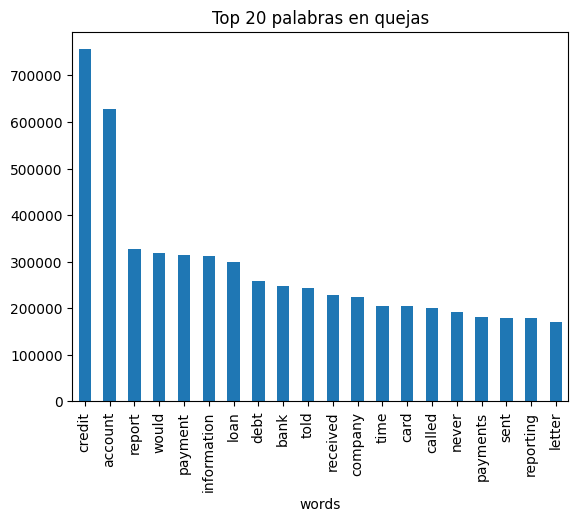

In [24]:
common_words = get_top_n_words(quejas["Consumer complaint narrative"], 20, 1)
for word, freq in common_words:
    print(word, freq)
    
df_top_words = pd.DataFrame(common_words, columns=["words", "count"])
df_top_words.groupby("words").sum()["count"].sort_values(ascending=False).plot(
    kind="bar", title="Top 20 palabras en quejas"
)